In [1]:
import pandas as pd
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import tensorflow as tf


import keras.src.optimizers.optimizer_v1
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, LeakyReLU

from sklearn.preprocessing import MinMaxScaler

In [2]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

In [3]:
PAX = pd.read_csv("air-traffic-passenger-statistics.csv")
PAX.loc[:, "Activity Period"] = pd.to_datetime(PAX.loc[:, "Activity Period"].astype(str), format="%Y%m")

df = PAX[['Activity Period', 'Passenger Count']]
df = df.groupby('Activity Period').sum()
df.sort_values(by='Activity Period', inplace=True)
df.head()

,Passenger Count
Activity Period,
2005-07-01,3225769
2005-08-01,3195866
2005-09-01,2740553
2005-10-01,2770715
2005-11-01,2617333


In [4]:
df.shape

(156, 1)

In [5]:
scaler = MinMaxScaler()
scaler.fit(df)
df['Passenger Count'] = scaler.transform(df)
df.head()

,Passenger Count
Activity Period,
2005-07-01,0.304433
2005-08-01,0.295354
2005-09-01,0.157122
2005-10-01,0.166279
2005-11-01,0.119712


In [6]:
X_raw = df.copy()

n_steps_in = 24
n_steps_out = 12

split_idx = 156 - (n_steps_in + n_steps_out + 1)
X_raw_train = X_raw[:split_idx]
X_raw_test = X_raw[split_idx:]

X_raw_test.shape

(37, 1)

In order to train LSTM-based DNN we have to prepare data. It is required in this case that each chunk of data contains an input vector and an output vector.
* Length of an input vector = number of steps to train DNN on
* Length of an output vector = a number of steps to predict

To achieve that I prepared a helper function below.

In [30]:
def split_sequence(sequence, n_input: int, n_output: int) -> np.array:
    """Splits a times series sequence into input and output sequences

    Args:
        sequence: a time series to be split
        n_input: number of input steps
        n_output: number of output steps

    Returns:
        two numpy arrays

    """
    x, y = [], []
    for i, _ in enumerate(sequence):
        input_end = i + n_input
        output_end = input_end + n_output - 1
        # stop if we reach end of the sequence
        if output_end > len(sequence):
            break

        seq_x, seq_y = sequence[i:input_end], sequence[input_end-1:output_end]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

Let's do a small test if the code works properly. For the sequence of numbers from 0 to 9, we want to split them into 3 steps for an input and 2 for an output. We should be able to generate 5 samples in total.

In [31]:
test_seq = [1,2,3,4,5,6,7,8,9,10]

In [32]:
a, b = split_sequence(test_seq, 3, 3)
a

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8]])

In [33]:
b

array([[ 3,  4,  5],
       [ 4,  5,  6],
       [ 5,  6,  7],
       [ 6,  7,  8],
       [ 7,  8,  9],
       [ 8,  9, 10]])

The helper function works properly. We can use it to split the real dataset into train and test sets.

In [28]:
X_train, y_train = split_sequence(X_raw_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(X_raw_test.values, n_steps_in, n_steps_out)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(83, 24, 1)
(83, 12, 1)
(1, 24, 1)
(1, 12, 1)


Below there is a visualisation of the first sample of the train set (input and output vectors).

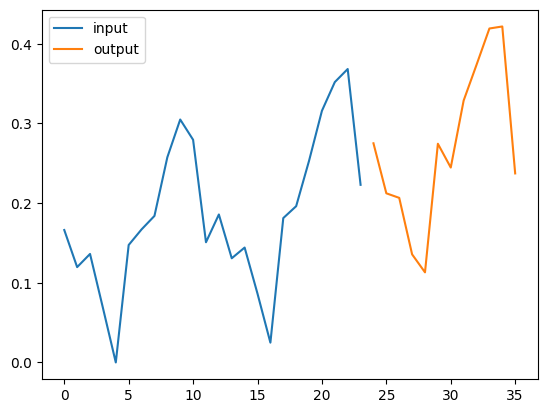

In [29]:
sample = 3

tmp = X_train[sample].flatten()
x_tmp = pd.DataFrame({'date': np.arange(len(tmp)), 'value': tmp}).set_index('date')

tmp = y_train[sample].flatten()
y_tmp = pd.DataFrame({'date': np.arange(n_steps_in, n_steps_in+len(tmp)), 'value': tmp}).set_index('date')

plt.plot(x_tmp, label="input")
plt.plot(y_tmp, label="output")
plt.legend()
plt.show()

In [4]:
# do we need this?

In [30]:
n_features = 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(83, 24, 1)
(83, 12, 1)
(1, 24, 1)
(1, 12, 1)


Fot the modelling I will the LSTM encoder-decoder architecture. In this case there are 2 encoder layers and 2 decoder ones. Parameters used here are defined below.

In [31]:
n_1 = 128
n_2 = 64
loss_metric = "mae"
lr = 0.0005
epochs = 10_000

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)

model = Sequential()

# layer 1
model.add(LSTM(n_1, input_shape=(n_steps_in, n_features), return_sequences=True))
model.add(LeakyReLU(alpha=0.05))
# layer 2
model.add(LSTM(n_2))
model.add(LeakyReLU(alpha=0.05))

model.add(RepeatVector(n_steps_out))

# layer 3
model.add(LSTM(n_2, return_sequences=True))
model.add(LeakyReLU(alpha=0.05))
# layer 4
model.add(LSTM(n_1, return_sequences=True))
model.add(LeakyReLU(alpha=0.05))

model.add(TimeDistributed(Dense(1)))

opt = keras.src.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss_metric)

In [36]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    batch_size=64,
                    callbacks=[callback],
                    workers=4)

Epoch 1/10000
2/2 [==============================] - 6s 1s/step - loss: 0.3719 - val_loss: 0.7660
Epoch 2/10000
2/2 [==============================] - 0s 47ms/step - loss: 0.3626 - val_loss: 0.7512
Epoch 3/10000
2/2 [==============================] - 0s 39ms/step - loss: 0.3506 - val_loss: 0.7295
Epoch 4/10000
2/2 [==============================] - 0s 31ms/step - loss: 0.3340 - val_loss: 0.6962
Epoch 5/10000
2/2 [==============================] - 0s 47ms/step - loss: 0.3098 - val_loss: 0.6428
Epoch 6/10000
2/2 [==============================] - 0s 47ms/step - loss: 0.2739 - val_loss: 0.5534
Epoch 7/10000
2/2 [==============================] - 0s 47ms/step - loss: 0.2210 - val_loss: 0.4101
Epoch 8/10000
2/2 [==============================] - 0s 47ms/step - loss: 0.1876 - val_loss: 0.3958
Epoch 9/10000
2/2 [==============================] - 0s 47ms/step - loss: 0.2075 - val_loss: 0.3719
Epoch 10/10000
2/2 [==============================] - 0s 48ms/step - loss: 0.1905 - val_loss: 0.3991
E

In [37]:
val_X_len = len(X_test.flatten())
val_X_len

In [42]:
preds = model.predict(X_test, verbose=0)
preds = preds.flatten()
preds

In [41]:
X_pred = preds.flatten()
output = pd.DataFrame({'date': np.arange(val_X_len, val_X_len+len(preds)),
                       'output': preds}).set_index("date", drop=True)
plt.plot(output, label='LSTM', c="r")

model_input = pd.DataFrame({'date': range(val_X_len),
                            'input': X_test.flatten()}).set_index("date", drop=True)
plt.plot(model_input, label='input')
plt.legend()
